In [1]:
# Notebook configuration

ALGODIRECT_HNSW_RESULTS_DIR = "/mnt/nas1/weaviate_benchmark_results/algodirect/jacob/redo"
GSI_HNSW_RESULTS_DIR = "/mnt/nas1/weaviate_benchmark_results/algodirect/sv7-apu11/gwilliams"

GT_DIR = "/mnt/nas1/fvs_benchmark_datasets" # requires nfs mount

In [2]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
import ipywidgets as widgets

In [3]:
#
# Algo Direct - HNSW
#

In [4]:
# Accumulate algodirect gemini results by recursively walking the results dir

csvs = []
gsi_csvs = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(ALGODIRECT_HNSW_RESULTS_DIR):
    for file in files:
        
        if file.endswith(".csv"):
            fpath = os.path.join(root, file)
            csvs.append(fpath)

for root, dir, files in os.walk(GSI_HNSW_RESULTS_DIR):
    for file in files:
        if file.endswith(".csv") and "flat" not in file:
            fpath = os.path.join(root, file)
            gsi_csvs.append(fpath)
# print(csvs)

In [5]:
# Load all hnsw csv results into one dataframe

gsi_dfs = []

for csvfile in gsi_csvs:
    # parse the file name for info
    _df = pd.read_csv(csvfile)
    parts = os.path.basename(csvfile).split("_")
    print(parts)
    if parts[2]=="work": continue
    _df['implementation']=parts[1]
    _df['machine']=parts[2]
    _df['dset']="deep-"+parts[3]  # TODO: make sure to change for different base dataset
    # skip idx 4 because it's cluster or flat
    _df['numrecs']=int(parts[5])
    _df['ef']=int(parts[6])
    _df['importtime']=float(parts[7])
    _df['walltime']=float(parts[8][:-4])
    gsi_dfs.append(_df)

gsi_df = pd.concat(gsi_dfs)
# print(df.columns, df.shape)

['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '10000000', '128', '18.743331', '18.743385.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '20000000', '128', '23.899939', '23.899986.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '2000000', '128', '4.636360', '4.636422.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '100000000', '256', '6602.383349', '6602.383382.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '1000000', '256', '2.424560', '2.424580.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '2000000', '256', '4.645472', '4.645534.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '100000000', '512', '175.812503', '175.812552.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '10000000', '512', '16.450884', '16.450965.csv']
['algodirect', 'gemini', 'sv7-apu11', 'deep1b', 'clusters', '1000000', '768', '3.056587', '3.056647.csv']
['algodirect', 'gemini'

In [6]:
# Load all hnsw csv results into one dataframe

dfs = []

for csvfile in csvs:
    # parse the file name for info
    _df = pd.read_csv(csvfile)
    parts = os.path.basename(csvfile).split("_")
    print(parts)
    if parts[2]=="work": continue
    _df['implementation']=parts[1]
    _df['machine']=parts[2]
    _df['dset']="deep-"+parts[3]  # TODO: make sure to change for different base dataset
    _df['numrecs']=int(parts[4])
    _df['ef']=int(parts[5])
    _df['importtime']=float(parts[6])
    _df['walltime']=float(parts[7][:-4])
    dfs.append(_df)

df = pd.concat(dfs)
# print(df.columns, df.shape)

['algodirect', 'hnsw', 'fractals-1', '100M', '100000000', '128', '141989.792003', '142015.029860.csv']
['algodirect', 'hnsw', 'fractals-1', '100M', '100000000', '256', '141989.792003', '142015.029860.csv']
['algodirect', 'hnsw', 'fractals-1', '100M', '100000000', '512', '141989.792003', '142015.029860.csv']
['algodirect', 'hnsw', 'fractals-1', '100M', '100000000', '64', '141989.792003', '142015.029860.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '128', '1.374504', '1.376540.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '256', '1.374504', '1.376540.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '512', '1.374504', '1.376540.csv']
['algodirect', 'hnsw', 'fractals-1', '10K', '10000', '64', '1.374504', '1.376540.csv']
['algodirect', 'hnsw', 'fractals-1', '10M', '10000000', '128', '7844.880081', '7846.929756.csv']
['algodirect', 'hnsw', 'fractals-1', '10M', '10000000', '256', '7844.880081', '7846.929756.csv']
['algodirect', 'hnsw', 'fractals-1', '10M', 

In [7]:
# Show the data

pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
#df

In [8]:
# compute recall via GT file

print(gsi_df.columns, gsi_df.shape)

# get all unique dataset sizes
sizes = gsi_df['numrecs'].unique()
sizes.sort()
print("all sizes=",sizes)

# get all unique bit sizes
efs = gsi_df['ef'].unique()
efs.sort()
print("all efs=",efs)

# create empty ecall10 column to be computed shortly
gsi_df['recall10']= None

def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))


# accumulate summaries for new dataframe
summaries = []

for ef in efs:
    for sz in sizes:
        # get the ground truth file for this numrecs size
        hsz = hsize(sz)
        gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % hsz)
        if not os.path.exists(gt_file):
            raise Exception("Cannot find "+ gt_file)
        gt = np.load(gt_file)
        #print(gt_file, gt.shape)
    
        # get the rows for this numrecs size
        gsi_df_sz = gsi_df[ (gsi_df['numrecs']==sz) & \
                    (gsi_df['ef']==ef) ]
        if gsi_df_sz.shape[0]==0:
            print("Nothing for bits=%d and numrecs=%d" % (ef, sz))
            continue
        elif gsi_df_sz.shape[0]!=1000:
            print("Warning: multiple runs across query set (%d,%d)" % \
                (ef,sz))
            
        # iterate all rows and compute recall
        for i in range(gsi_df_sz.shape[0]):
            # get query index
            q_i = gsi_df_sz.iloc[i, list(gsi_df.columns).index('q_index') ]
            # get the search indices for this query index
            inds = [ int(ith) \
                for ith in \
                    gsi_df_sz.iloc[i, list(gsi_df.columns).index('inds')]
                        .replace("=","-").split("-") ]
            #print(q_i)
            # get the associated ground truth indices for this query for k=10
            gt10 = gt[q_i][0:10]
            # compute intersection for recall
            isec = np.intersect1d( gt10, inds)
            recall10 = len(isec)/10.0
            # apply to this row
            gsi_df_sz.at[i,'recall10'] = recall10
    
        # compute mean recall
        recall10_mean = gsi_df_sz['recall10'].mean()
    
        # compute mean search time 
        search_mean = (gsi_df_sz['search_time'].mean()) * 1000.0
    
        # grab the train time
        import_time = gsi_df_sz['importtime'].mean()
        
        # grab the wall import time
        wall_time = gsi_df_sz['walltime'].mean()
        
        #print(bt, sz, recall10_mean, search_mean, train_time, wall_time )
        summary = {'ef':ef, 'numrecs':sz, \
                   'recall10_mean': recall10_mean, \
                   'search_mean': search_mean, \
                   'import_time': import_time, \
                   'wall_time': wall_time }
        summaries.append(summary)

summary_gsi_df = pd.DataFrame(summaries)
summary_gsi_df = summary_gsi_df[summary_gsi_df['ef'] != 768]
print(summary_gsi_df)

print("Done")

Index(['ts', 'q_index', 'search_time', 'inds', 'implementation', 'machine',
       'dset', 'numrecs', 'ef', 'importtime', 'walltime'],
      dtype='object') (40000, 11)
all sizes= [  1000000   2000000   5000000  10000000  20000000  50000000 100000000
 250000000 500000000]
all efs= [ 64 128 256 512 768]
Nothing for bits=64 and numrecs=250000000
Nothing for bits=64 and numrecs=500000000
Nothing for bits=512 and numrecs=250000000
Nothing for bits=768 and numrecs=250000000
Nothing for bits=768 and numrecs=500000000
     ef    numrecs  recall10_mean  search_mean   import_time     wall_time
0    64    1000000         0.9624    22.011360      2.233583      2.233616
1    64    2000000         0.9474    22.492887      4.389998      4.390045
2    64    5000000         0.9233    23.612933     10.721548     10.721599
3    64   10000000         0.8865    24.905373     18.433649     18.433715
4    64   20000000         0.8889    26.472284     35.921844     35.921897
5    64   50000000         0.8343

In [9]:
# interpolate 250M, 512 bit search and recall

agg = summary_gsi_df[(summary_gsi_df.numrecs == 100000000) | (summary_gsi_df.numrecs == 500000000)].groupby('ef').mean()
interp_recall, interp_search = agg.loc[[512]][['recall10_mean', 'search_mean']].values.tolist()[0]
tmp = [512, 250000000, interp_recall, interp_search, None, None]
summary_gsi_df.index = [x + 1 if x == 32 else x for x in summary_gsi_df.index]
summary_gsi_df.loc[32] = tmp
summary_gsi_df.numrecs, summary_gsi_df.ef = summary_gsi_df.numrecs.astype(int), summary_gsi_df.ef.astype(int)
summary_gsi_df.sort_index(inplace=True)

In [10]:
# compute recall via GT file

print(df.columns, df.shape)

# get all unique dataset sizes
sizes = df['numrecs'].unique()
sizes.sort()
print("all sizes=",sizes)

# get all unique bit sizes
efs = df['ef'].unique()
efs.sort()
print("all efs=",efs)

# create empty ecall10 column to be computed shortly
df['recall10']= None

def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))


# accumulate summaries for new dataframe
summaries = []

for ef in efs:
    for sz in sizes:
        # get the ground truth file for this numrecs size
        hsz = hsize(sz)
        gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % hsz)
        if not os.path.exists(gt_file):
            raise Exception("Cannot find "+ gt_file)
        gt = np.load(gt_file)
        #print(gt_file, gt.shape)
    
        # get the rows for this numrecs size
        df_sz = df[ (df['numrecs']==sz) & \
                    (df['ef']==ef) ]
        if df_sz.shape[0]==0:
            print("Nothing for bits=%d and numrecs=%d" % (ef, sz))
            continue
        elif df_sz.shape[0]!=1000:
            print("Warning: multiple runs across query set (%d,%d)" % \
                (ef,sz))
            
        # iterate all rows and compute recall
        for i in range(df_sz.shape[0]):
            # get query index
            q_i = df_sz.iloc[i, list(df.columns).index('q_index') ]
            # get the search indices for this query index
            inds = [ int(ith) \
                for ith in \
                    df_sz.iloc[i, list(df.columns).index('inds')]
                        .replace("=","-").split("-") ]
            #print(q_i)
            # get the associated ground truth indices for this query for k=10
            gt10 = gt[q_i][0:10]
            # compute intersection for recall
            isec = np.intersect1d( gt10, inds)
            recall10 = len(isec)/10.0
            # apply to this row
            df_sz.at[i,'recall10'] = recall10
    
        # compute mean recall
        recall10_mean = df_sz['recall10'].mean()
    
        # compute mean search time 
        search_mean = (df_sz['search_time'].mean()) * 1000.0
    
        # grab the train time
        import_time = df_sz['importtime'].mean()
        
        # grab the wall import time
        wall_time = df_sz['walltime'].mean()
        
        #print(bt, sz, recall10_mean, search_mean, train_time, wall_time )
        summary = {'ef':ef, 'numrecs':sz, \
                   'recall10_mean': recall10_mean, \
                   'search_mean': search_mean, \
                   'import_time': import_time, \
                   'wall_time': wall_time }
        summaries.append(summary)

summary_df = pd.DataFrame(summaries)
print(summary_df)

print("Done")

Index(['ts', 'q_index', 'search_time', 'inds', 'implementation', 'machine',
       'dset', 'numrecs', 'ef', 'importtime', 'walltime'],
      dtype='object') (40000, 11)
all sizes= [    10000   1000000   2000000   5000000  10000000  20000000  50000000
 100000000 250000000 500000000]
all efs= [ 64 128 256 512]
     ef    numrecs  recall10_mean  search_mean   import_time     wall_time
0    64      10000         0.9959     0.129360  1.374504e+00  1.376540e+00
1    64    1000000         0.9537     0.587304  5.234569e+02  5.237424e+02
2    64    2000000         0.9420     0.691642  8.468969e+02  8.472308e+02
3    64    5000000         0.9328     1.347785  3.604795e+03  3.605949e+03
4    64   10000000         0.9208     1.569568  7.844880e+03  7.846930e+03
5    64   20000000         0.9025     2.023533  3.119272e+04  3.120085e+04
6    64   50000000         0.8802     2.511672  7.145397e+04  7.146827e+04
7    64  100000000         0.8710     2.715001  1.419898e+05  1.420150e+05
8    64  250000

train time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.022908400000000006, 8.724282183333333, 14.114947850000004, 60.07991563333333, 130.74800134999998, 519.8787175833334, 1190.8995059833335, 2366.4965333833325, 14252.496112449995, 25945.56635725001]
wall import time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.02294233333333333, 8.729039533333331, 14.12051263333333, 60.09915296666667, 130.7821626, 520.0142301333332, 1191.137864216667, 2366.9171643333343, 14254.660947649996, 25947.94936113333]


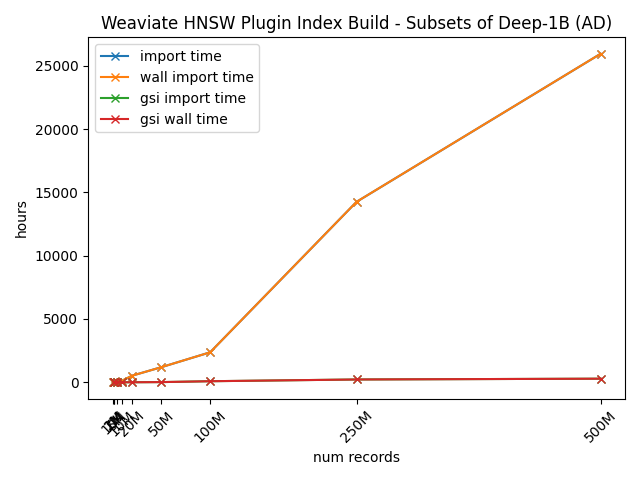

In [11]:
# Plot import/train times

# compute average train time via groupby
avg_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['import_time'].mean()

# compute average wall import time via groupby
avg_wall_import_time = \
    summary_df.groupby( [ 'numrecs' ] ) ['wall_time'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx
    xs.append(x)
    y = avg_import_time[idx]/(60.0)
    ys.append(y)
print("train time", xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0)
    wys.append(y)
print("wall import time", wxs,wys)

avg_import_time = \
    summary_gsi_df.groupby(['numrecs'])['import_time'].mean()
avg_wall_import_time = \
    summary_gsi_df.groupby(['numrecs'])['wall_time'].mean()
xgs = []
ygs = []
for idx in avg_import_time.index:
    x = idx
    xgs.append(x)
    y = avg_import_time[idx]/(60.0)
    ygs.append(y)
wxgs = []
wygs = []
for idx in avg_wall_import_time.index:
    x = idx
    wxgs.append(x)
    y = avg_wall_import_time[idx]/(60.0)
    wygs.append(y)

# plot the lines and label the plot
fig, ax = plt.subplots()
ax.plot(xs,ys, marker='x', label="import time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.plot(xgs,ygs, marker='x', label="gsi import time")
ax.plot(wxgs,wygs, marker='x', label="gsi wall time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M', '2M', '5M', '10M', '20M', '50M', '100M', '250M', '500M'], rotation = 45)
ax.set_title("Weaviate HNSW Plugin Index Build - Subsets of Deep-1B (AD)")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_build_time_ad.png")

# TODO:  plot the variance at each X

In [12]:
summary_gsi_df

,ef,numrecs,recall10_mean,search_mean,import_time,wall_time
0,64,1000000,0.9624,22.011360,2.233583,2.233616
1,64,2000000,0.9474,22.492887,4.389998,4.390045
2,64,5000000,0.9233,23.612933,10.721548,10.721599
3,64,10000000,0.8865,24.905373,18.433649,18.433715
4,64,20000000,0.8889,26.472284,35.921844,35.921897
5,64,50000000,0.8343,29.009352,2889.250224,2889.250275
6,64,100000000,0.7842,33.661810,6391.818142,6391.818214
7,128,1000000,0.9926,25.994667,2.375549,2.375591
8,128,2000000,0.9905,26.687729,4.636360,4.636422
9,128,5000000,0.9819,28.363956,9.909256,9.909271


In [13]:
def format_size(size):
    if size < 1000000:      
        return str(size)[:-3]+'K'
    elif size < 1000000000:
        return str(size)[:-6]+'M'
    else:
        return str(size)[:-9]+'B'

def unformat_size(size):
    if size[-1] == 'K':
        return int(size[:-1]) * 1000
    elif size[-1] == 'M':
        return int(size[:-1]) * 1000000
    else:
        return int(size[:-1]) * 1000000000

interactive(children=(FloatSlider(value=1.0, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

interactive(children=(Checkbox(value=False, description='GSI_pareto'), Output()), _dom_classes=('widget-intera…

interactive(children=(Checkbox(value=False, description='Weaviate_pareto'), Output()), _dom_classes=('widget-i…

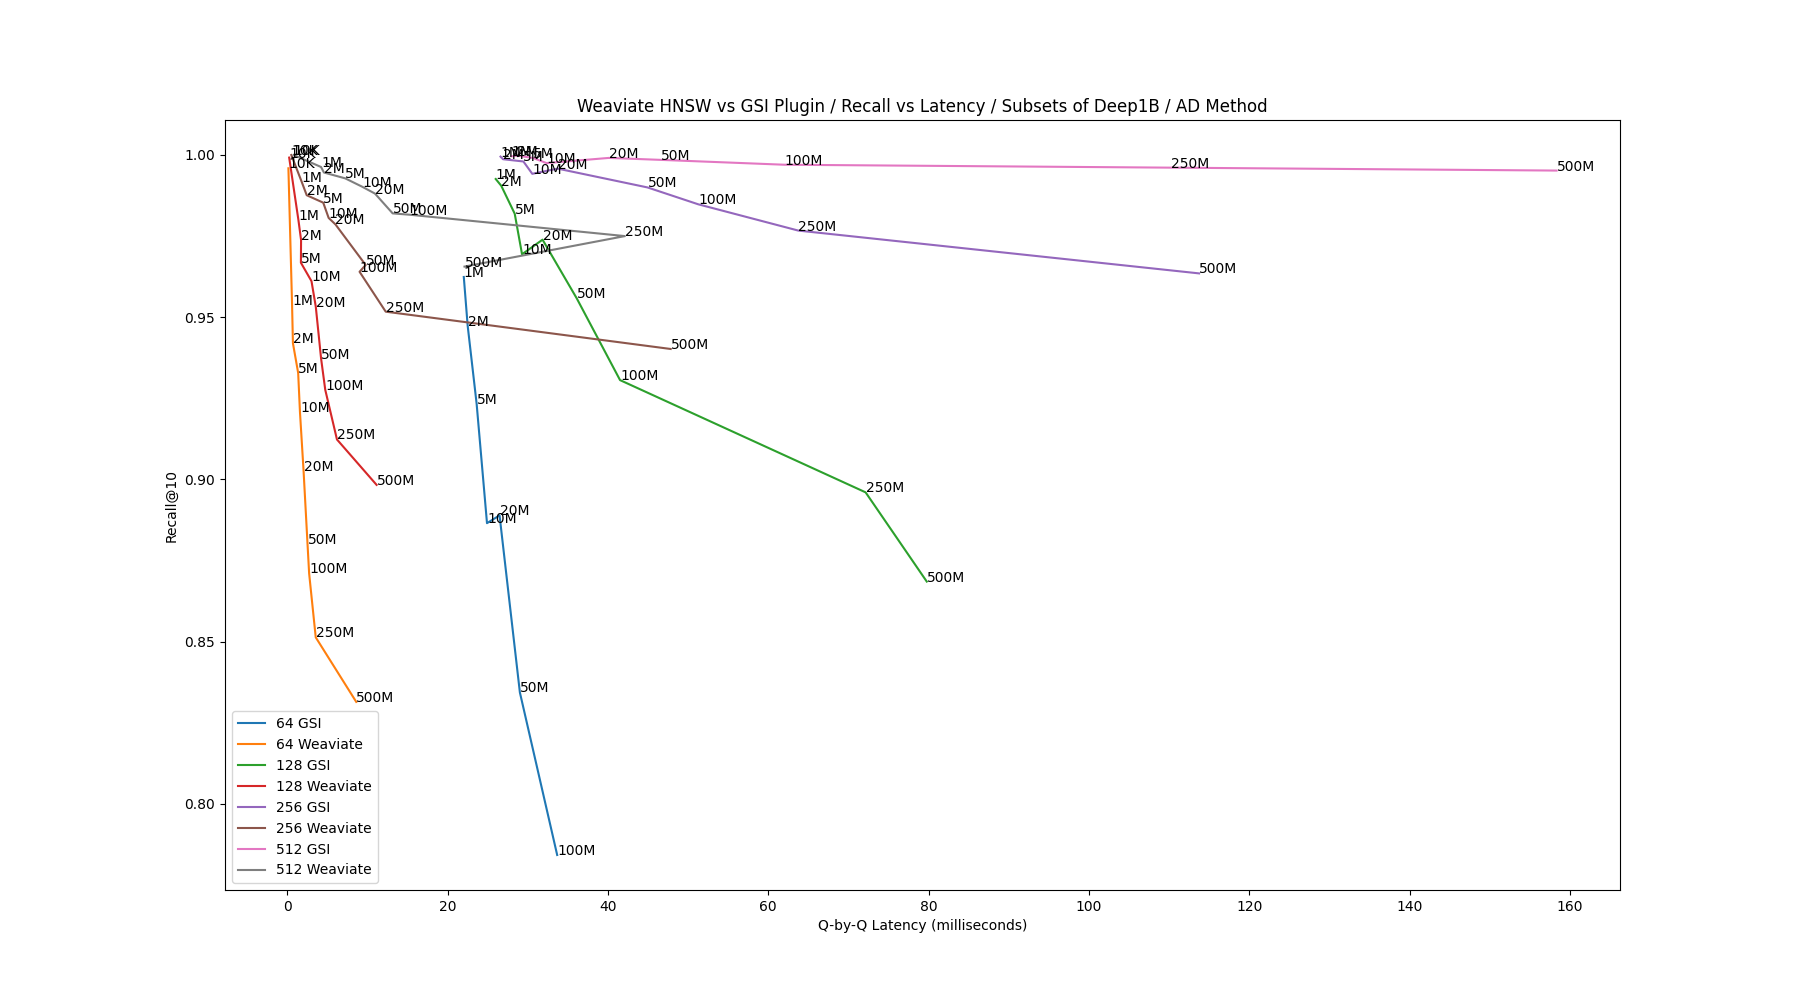

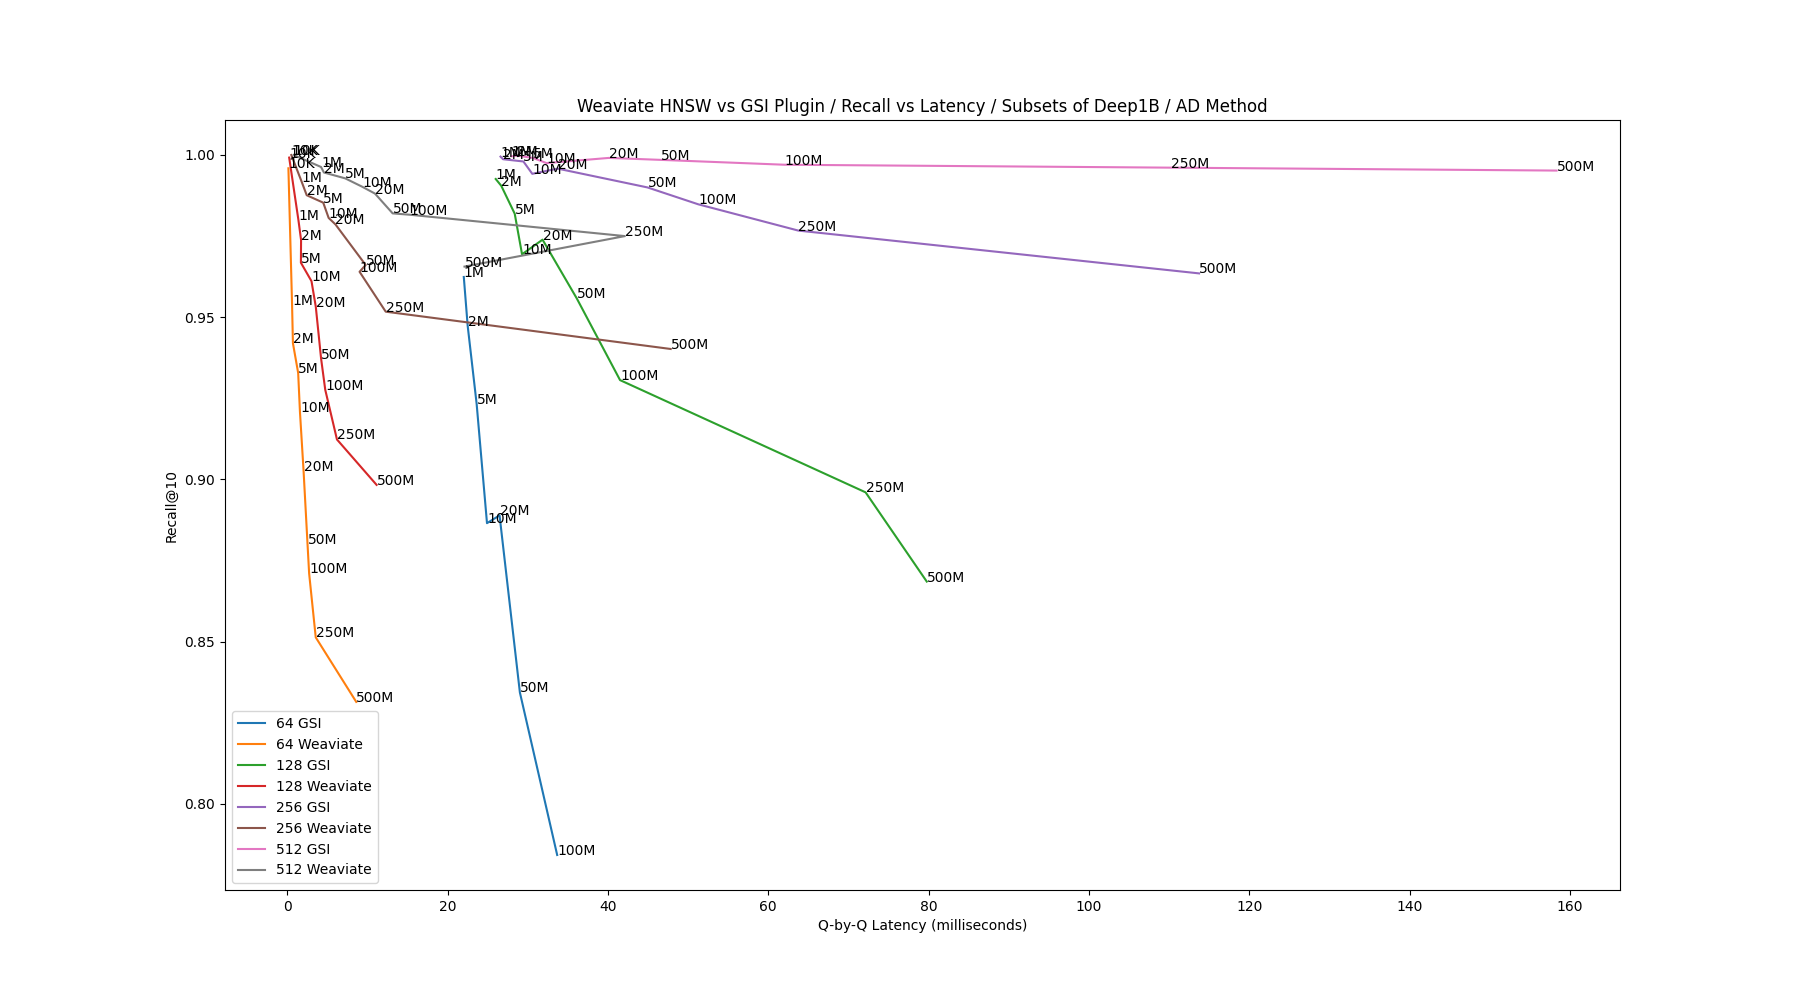

In [14]:
ann_list, lines = [], []
gsi_pareto_list, pareto_list = [], []
def set_graph(a):
    global ann_list
    global lines
    for ef in summary_gsi_df.ef.unique():
        tmp = summary_gsi_df[summary_gsi_df.ef == ef]
        lines.append(plt.plot(tmp.search_mean, tmp.recall10_mean, label = str(ef) + ' GSI', alpha=a))
        for i, j, s in zip(tmp.search_mean, tmp.recall10_mean, tmp.numrecs):
            ann_list.append(plt.annotate(format_size(s), (i,j), alpha=a))
        tmp = summary_df[summary_df.ef == ef]
        lines.append(plt.plot(tmp.search_mean, tmp.recall10_mean, label = str(ef) + " Weaviate", alpha=a))
        for i, j, s in zip(tmp.search_mean, tmp.recall10_mean, tmp.numrecs):
            ann_list.append(plt.annotate(format_size(s), (i,j), alpha=a))

fig, ax = plt.subplots(figsize=(18,10))
@widgets.interact(a=(0,1,0.1))
def update(a=1.0):
    global ann_list
    global lines
    for ann in ann_list:
        ann.remove()
    ann_list[:] = []
    [line.pop(0).remove() for line in lines if len(line) > 0]
    lines[:] = []
    set_graph(a)

gsi_pareto_list = []
@widgets.interact(GSI_pareto=False)
def show_gsi_pareto(GSI_pareto):
    global gsi_pareto_list
    if GSI_pareto:
        for size in summary_gsi_df.numrecs.unique():
            if size < 10000000:
                continue
            tmp = summary_gsi_df[summary_gsi_df.numrecs == size]
            gsi_pareto_list.append(plt.plot(tmp.search_mean, tmp.recall10_mean, color='black', linestyle='dashed'))
    else:
        [line.pop(0).remove() for line in gsi_pareto_list]
        gsi_pareto_list = []

pareto_list = []
@widgets.interact(Weaviate_pareto=False)
def show_weav_pareto(Weaviate_pareto):
    global pareto_list
    if Weaviate_pareto:
        for size in summary_df.numrecs.unique():
            if size < 10000000:
                continue
            tmp = summary_df[summary_df.numrecs == size]
            pareto_list.append(plt.plot(tmp.search_mean, tmp.recall10_mean, color='black', linestyle='dashed'))
    else:
        [line.pop(0).remove() for line in pareto_list if len(line) > 0]
        pareto_list = []


ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate HNSW vs GSI Plugin / Recall vs Latency / Subsets of Deep1B / AD Method")
ax.legend()
fig.show()

In [15]:
# select 1 dataset size
# colored pareto front

In [16]:
from ipywidgets import Layout, HBox
from IPython.display import clear_output

In [29]:
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'pink', 'teal', 'orange', 'brown', 'gray']
def set_graph(change):
    update(change)
    global ann_list
    global lines
    global weav
    global gsi
    global p_mode

    if change['new'] == ('GSI', ):
        gsi, weav = True, False
        return
    elif change['new'] == ('Weaviate', ):
        gsi, weav = False, True
        return
    elif change['new'] == ('GSI', 'Weaviate'):
        gsi, weav = True, True
        return
    
    if type(change['new']) == bool:
        p_mode = not p_mode
        return
    
    lines = []
    ann_list = []
    if p_mode:
        for color, size in enumerate(change['new']):
            if gsi:
                tmp = summary_gsi_df[summary_gsi_df.numrecs == unformat_size(size)]
                lines.append(plt.plot(tmp.search_mean, tmp.recall10_mean, '-o', label=str(size) + ' GSI', color=colors[color]))
                for i, j, s in zip(tmp.search_mean, tmp.recall10_mean, tmp.ef):
                    ann_list.append(plt.annotate(s, (i,j)))
            if weav:
                tmp = summary_df[summary_df.numrecs == unformat_size(size)]
                lines.append(plt.plot(tmp.search_mean, tmp.recall10_mean, '-o', label=str(size) + ' Weaviate', color=colors[::-1][color]))
                for i, j, s in zip(tmp.search_mean, tmp.recall10_mean, tmp.ef):
                    ann_list.append(plt.annotate(s, (i,j)))
    else:
        for color, ef in enumerate(summary_gsi_df.ef.unique()):
            if gsi:
                tmp = summary_gsi_df[(summary_gsi_df.ef == ef) & (summary_gsi_df.numrecs.isin([unformat_size(x) for x in change['new']]))]
                lines.append(plt.plot(tmp.search_mean, tmp.recall10_mean, '-o', label = str(ef) + ' GSI', color=colors[color]))
                for i, j, s in zip(tmp.search_mean, tmp.recall10_mean, tmp.numrecs):
                    ann_list.append(plt.annotate(format_size(s), (i,j)))
            if weav:
                tmp = summary_df[(summary_df.ef == ef) & (summary_df.numrecs.isin([unformat_size(x) for x in change['new']]))]
                lines.append(plt.plot(tmp.search_mean, tmp.recall10_mean, '-o', label = str(ef) + " Weaviate", color=colors[::-1][color]))
                for i, j, s in zip(tmp.search_mean, tmp.recall10_mean, tmp.numrecs):
                    ann_list.append(plt.annotate(format_size(s), (i,j)))
    ax.legend()

def update(change):
    global ann_list
    global lines
    for ann in ann_list:
        ann.remove()
    ann_list[:] = []
    [line.pop(0).remove() for line in lines if len(line) > 0]
    lines[:] = []
    plt.close(0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


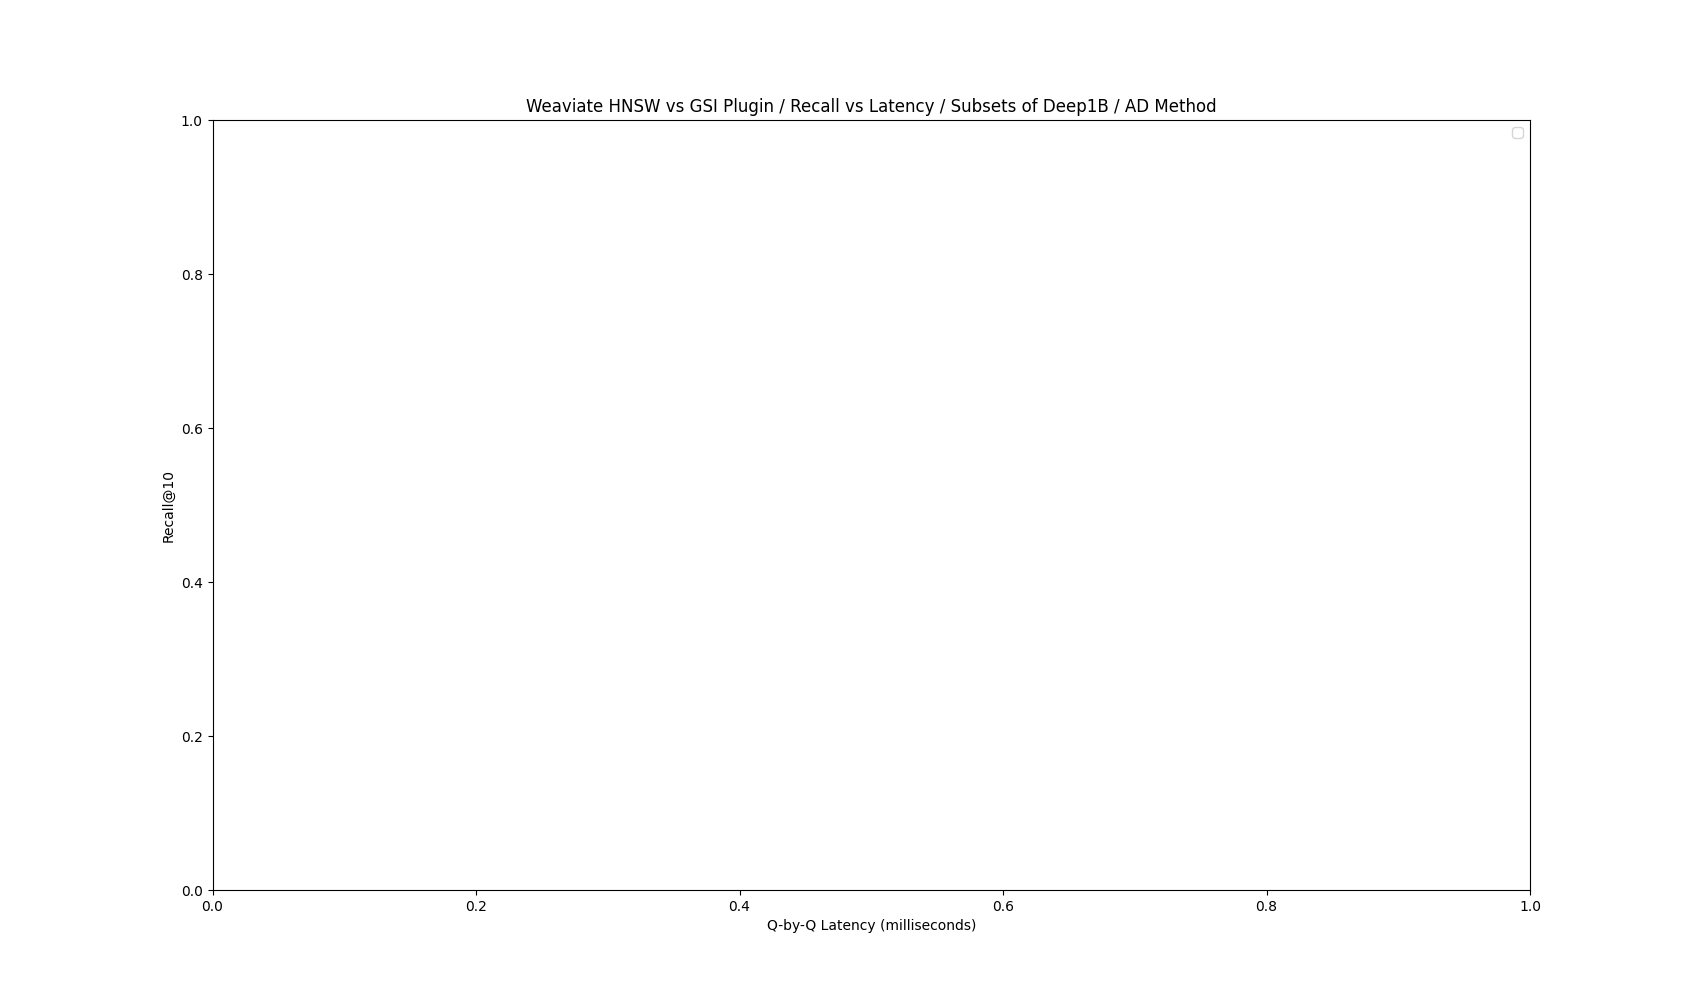

In [30]:
sm = widgets.SelectMultiple(
    options = ['GSI', 'Weaviate'],
    layout=Layout(height='50px', width='100px')
)
sm_size = widgets.SelectMultiple(
    options=[format_size(size) for size in sizes],
    layout=Layout(width='40px', height='180px')
)
pareto = widgets.Checkbox(
    value=False,
    description='pareto mode'
)

def on_value_change(change):
    print(change['new'])
    print('change: ', change)

sm.observe(set_graph, names='value')
sm_size.observe(set_graph, names='value')
pareto.observe(set_graph, names='value')
weav, gsi, p_mode = False, False, False
fig, ax = plt.subplots(figsize=(17,10))
ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate HNSW vs GSI Plugin / Recall vs Latency / Subsets of Deep1B / AD Method")
ax.legend()
HBox([sm, sm_size, pareto])


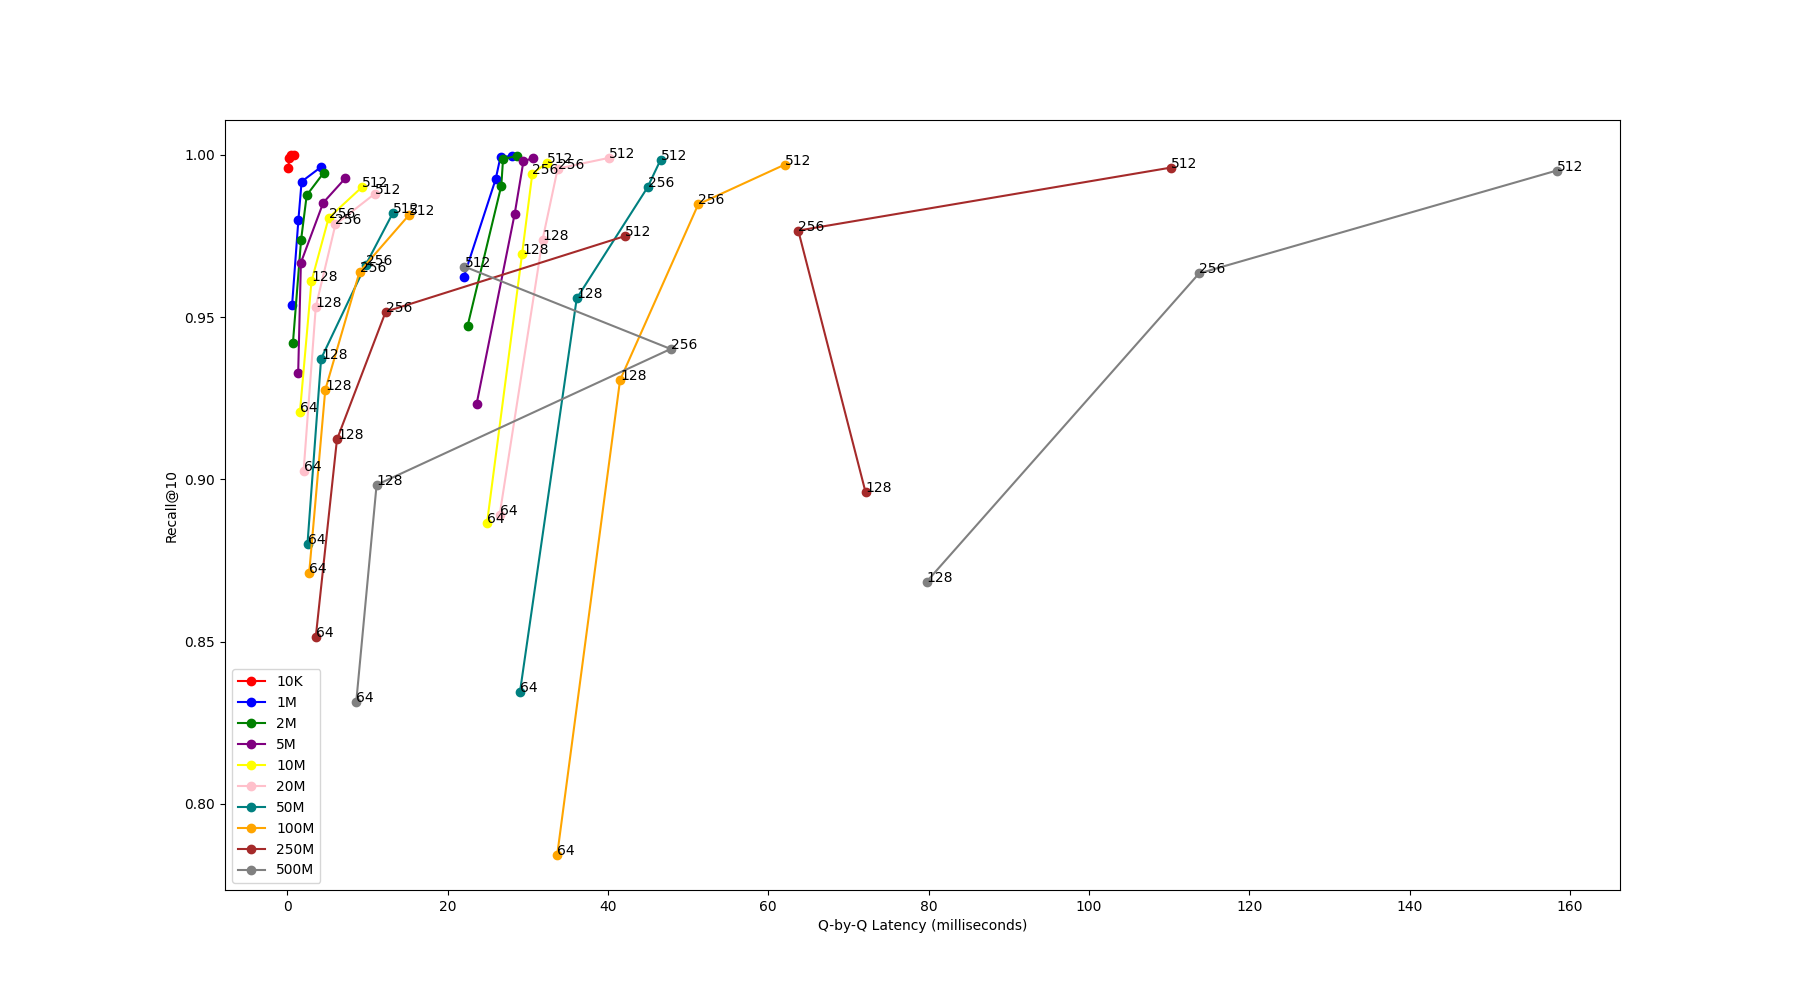

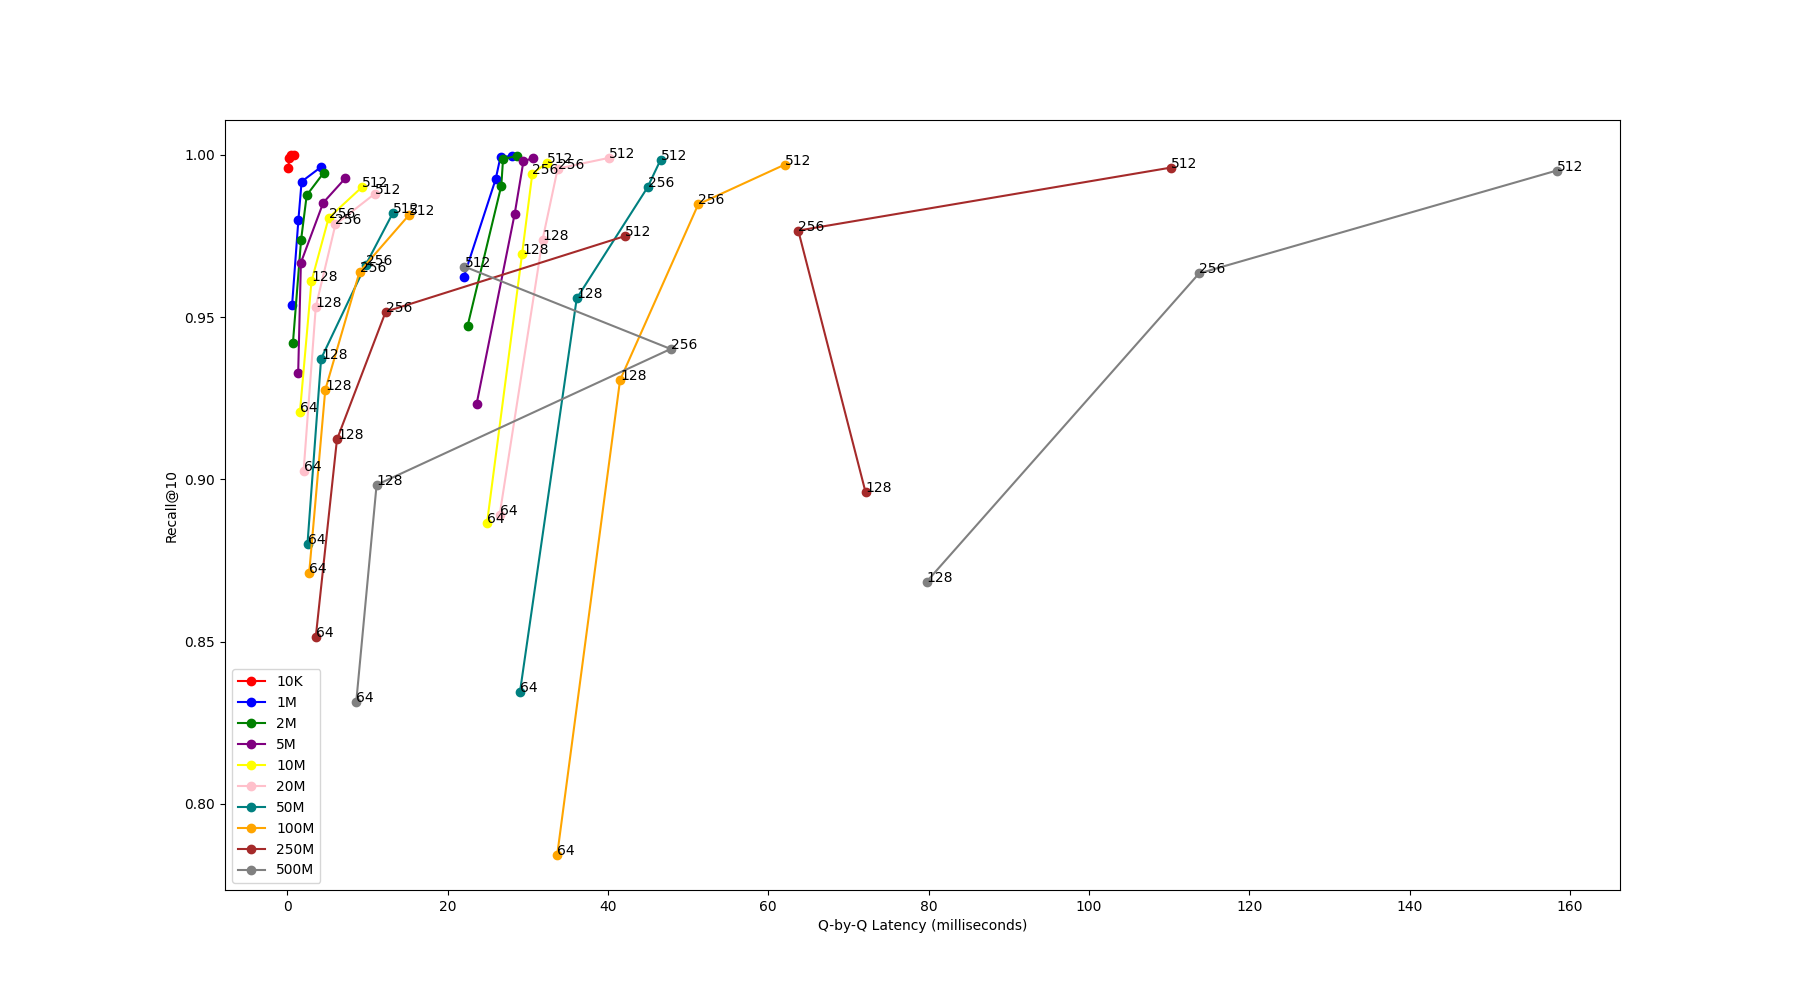

In [19]:
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'pink', 'teal', 'orange', 'brown', 'gray']
fig, ax = plt.subplots(figsize=(18,10))
for idx, size in enumerate(summary_df.numrecs.unique()):
    tmp = summary_df[summary_df.numrecs == size]
    plt.plot(tmp.search_mean, tmp.recall10_mean, '-o', label=format_size(size), color=colors[idx])
    if size >= 10000000:
        for i, j, ef in zip(tmp.search_mean, tmp.recall10_mean, tmp.ef):
            plt.annotate(ef, (i,j))
    tmp = summary_gsi_df[summary_gsi_df.numrecs == size]
    plt.plot(tmp.search_mean, tmp.recall10_mean, '-o', color=colors[idx])
    if size >= 10000000:
        for i, j, ef in zip(tmp.search_mean, tmp.recall10_mean, tmp.ef):
            plt.annotate(ef, (i, j))


ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.legend()
fig.show()